Fetching data for: ['AAPL', 'MSFT', 'GOOG', 'BTC-USD']


[*********************100%***********************]  4 of 4 completed



Portfolio Daily Mean Return: 0.0008585596630454788
Portfolio Daily Volatility : 0.014611975305111748

PARAMETRIC VaR 95% : $-2489.312024058388
HISTORICAL VaR % : $2305.921182069502
MONTE CARLO VaR 95% : $2333.173820942436
EXPECTED SHORTFALL (CVaR): $2991.2284043525856


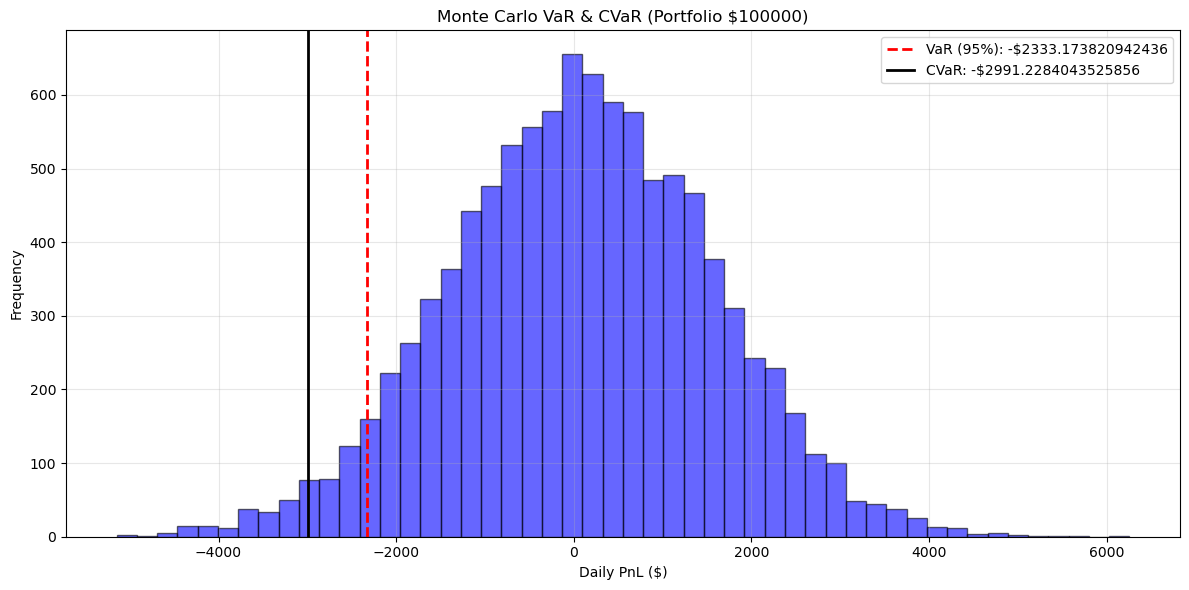

In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

portfolio = {'AAPL': 0.40, 'MSFT': 0.30, 'GOOG': 0.20, 'BTC-USD': 0.10}

portfolio_value = 100000
confidence = 0.95
horizon = 1

tickers = list(portfolio.keys())
wts = np.array(list(portfolio.values()))

print("Fetching data for:", tickers)

data = yf.download(tickers, period="2y")['Close']
returns = np.log(data / data.shift(1))
returns = returns.dropna(how="any")

mean = returns.mean()
cov = returns.cov()

port_mean = np.dot(wts, mean)
port_vol  = np.sqrt(wts.T @ cov @ wts)

print(f"\nPortfolio Daily Mean Return: {port_mean:}")
print(f"Portfolio Daily Volatility : {port_vol:}")

z = norm.ppf(1 - confidence)
parametric_var = -(port_mean - z * port_vol) * portfolio_value

print(f"\nPARAMETRIC VaR 95% : ${parametric_var:}")

hist_returns = returns @ wts
hist_pnl = hist_returns * portfolio_value

hist_var = -np.percentile(hist_pnl, (1 - confidence) * 100)
print(f"HISTORICAL VaR % : ${hist_var:}")

cov_pd = cov + 1e-6 * np.eye(len(cov))

L = np.linalg.cholesky(cov_pd)

simulations = 10000
rand = np.random.normal(0, 1, size=(len(tickers), simulations))
simulated_returns = mean.values.reshape(-1,1) + L @ rand

simulated_returns = wts @ simulated_returns
simulated_pnl = simulated_returns.flatten() * portfolio_value

mc_var = -np.percentile(simulated_pnl, (1 - confidence) * 100)
print(f"MONTE CARLO VaR 95% : ${mc_var:}")

tail_losses = simulated_pnl[simulated_pnl <= -mc_var]
cvar = -np.mean(tail_losses)

print(f"EXPECTED SHORTFALL (CVaR): ${cvar:}")

plt.figure(figsize=(12, 6))
plt.hist(simulated_pnl, bins=50, color='blue', alpha=0.6, edgecolor='black')
plt.axvline(-mc_var, color='red', linestyle='--', linewidth=2,
            label=f'VaR ({int(confidence*100)}%): -${mc_var:}')
plt.axvline(-cvar, color='black', linestyle='-', linewidth=2,
            label=f'CVaR: -${cvar:}')

plt.title(f'Monte Carlo VaR & CVaR (Portfolio ${portfolio_value:})')
plt.xlabel('Daily PnL ($)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('VaR.png')
plt.show()